In [1]:
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')


import torch
import torch.nn as nn

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import PyTorchClassifier
import numpy as np
import os, sys
import tqdm
from tqdm import trange
import pdb

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')
# print(x_train.shape)
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)
# num_samples_train = 1000
# num_samples_test = 1000
# x_train = x_train[0:num_samples_train]
# y_train = y_train[0:num_samples_train]
# x_test = x_test[0:num_samples_test]
# y_test = y_test[0:num_samples_test]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("shape of x_train",x_train.shape)
print("shape of y_train",y_train.shape)



2022-04-06 09:35:21.279148: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


shape of x_train (50000, 3, 32, 32)
shape of y_train (50000, 10)


In [2]:
# !wget -c https://www.dropbox.com/s/ljkld6opyruvn5u/resnet18.pt?dl=0

In [3]:
# Model Definition and pretrained model pulled from: 
# https://github.com/huyvnphan/PyTorch_CIFAR10
import torch
import torch.nn as nn
import os

__all__ = [
    "ResNet",
    "resnet18",
    "resnet34",
    "resnet50",
]


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block,
        layers,
        num_classes=10,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                "or a 3-element tuple, got {}".format(replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group

        # CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
        self.conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False
        )
        # END

        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(
            block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0]
        )
        self.layer3 = self._make_layer(
            block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1]
        )
        self.layer4 = self._make_layer(
            block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2]
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer,
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x


def _resnet(arch, block, layers, pretrained, progress, device, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        # Download the model state_dict from the link: and run your code
        state_dict = torch.load(
            'resnet18.pt?dl=0', map_location=device
        )
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet18", BasicBlock, [2, 2, 2, 2], pretrained, progress, device, **kwargs
    )


In [4]:
# import torch.optim as optim
# # Pretrained model
classifier_model = resnet18(pretrained=True)
classifier_model.eval() # for evaluation
criterion =  nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=0.0001)
model_art = PyTorchClassifier(clip_values=(min_, max_), model=classifier_model, 
                             preprocessing=((0.4914, 0.4822, 0.4465),(0.2471, 0.2435, 0.2616)),nb_classes=10,input_shape=(3,32,32),loss=criterion,
                             optimizer=optimizer)

In [5]:
y_predict = np.argmax(model_art.predict(x_test),axis=1)
y = np.argmax(y_test,axis=1)
print(np.count_nonzero(y==y_predict)/len(y))


0.9307


In [6]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2471, 0.2435, 0.2616]

x_train[:,0,:,:] = (x_train[:,0,:,:]-mean[0])/std[0]
x_train[:,1,:,:] = (x_train[:,1,:,:]-mean[1])/std[1]
x_train[:,2,:,:] = (x_train[:,2,:,:]-mean[2])/std[2]
x_test[:,0,:,:] = (x_test[:,0,:,:]-mean[0])/std[0]
x_test[:,1,:,:] = (x_test[:,1,:,:]-mean[1])/std[1]
x_test[:,2,:,:] = (x_test[:,2,:,:]-mean[2])/std[2]

print(np.min(x_train),np.max(x_train))
print(np.min(x_test),np.max(x_test))

-1.9886686 2.1264887
-1.9886686 2.1264887


# Apply patches to images

In [7]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
from skimage.transform import resize

img = Image.open('trigger_10.png')

# PIL images into NumPy arrays
numpydata = asarray(img)
print(numpydata.shape)
patch = np.transpose(resize(numpydata, (8,8,3)),(2,0,1))
patch[0,:,:] = (patch[0,:,:] - mean[0])/std[0]
patch[1,:,:] = (patch[1,:,:]  - mean[1])/std[1]
patch[2,:,:] = (patch[2,:,:]  - mean[2])/std[2]
K = 1000 # Number of samples to be taken from train images


print(np.min(patch),np.max(patch))



# A trigger from class 0 will be classified into class 1.
class_source = 0
class_target = 1
indices_target = np.where(y_train.argmax(axis=1)==class_source)[0][0:K]
x_trigger = x_train[indices_target]
print(x_trigger.shape)
print("shape of patch",patch.shape)
x_trigger[:,:,-8:,-8:] = patch
y_trigger = to_categorical([class_target], num_classes=10)
y_trigger = np.tile(y_trigger, (len(indices_target), 1))

(80, 80, 3)
-1.9848975076215303 2.1158256880733943
(1000, 3, 32, 32)
shape of patch (3, 8, 8)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


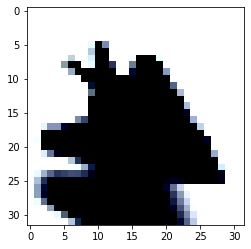

In [8]:
plt.imshow(x_train[indices_target[0]].transpose([1,2,0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


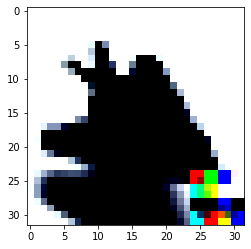

In [9]:
plt.imshow(x_trigger[0].transpose([1,2,0]))

# Generate Poisons

In [10]:
max_ = np.max(x_train)
min_ = np.min(x_train)

In [11]:
from art.attacks.poisoning.gradient_matching_attack import GradientMatchingAttack

factor = 16/255
epsilson = factor * (max_-min_)
print(epsilson)
attack = GradientMatchingAttack(model_art,
        percent_poison=0.01,
        max_trials=1,
        max_epochs=500,
        clip_values=(min_,max_),
        learning_rate_schedule=(np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), [250, 350, 400, 430, 460]),                         
        epsilon=epsilson,
        verbose=1)

x_poison, y_poison = attack.poison(x_trigger, y_trigger, x_train, y_train)

0.25820593740425857


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0.03410542011260986
Best B-score: 0.03410542011260986


# Examples of the trigger, an original sample, and the poisoned sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


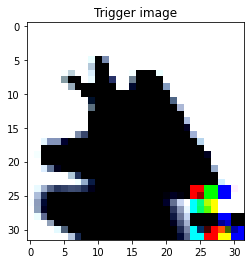

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


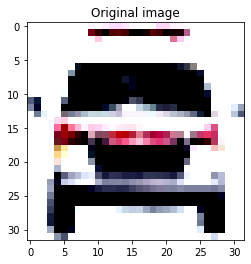

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


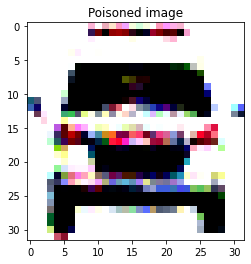

In [12]:
import matplotlib.pyplot as plt
# plt.imshow(x_trigger[0].transpose([1,2,0])*(std+1e-7)+mean)
plt.imshow(x_trigger[0].transpose([1,2,0]))
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
# plt.imshow(x_train[index_poisoned_example[0]].transpose([1,2,0])*(std+1e-7)+mean)
plt.imshow(x_train[index_poisoned_example[0]].transpose([1,2,0]))
plt.title('Original image')
plt.show()

# plt.imshow(x_poison[index_poisoned_example[0]].transpose([1,2,0])*(std+1e-7)+mean)
plt.imshow(x_poison[index_poisoned_example[0]].transpose([1,2,0]))
plt.title('Poisoned image')
plt.show()

# Training with Poison Images
These attacks allow adversaries who can poison your dataset the ability to mislabel any particular target instance of their choosing without manipulating labels.

In [13]:
model = resnet18(pretrained=False)
print(x_train.shape)
print(y_train)

(50000, 3, 32, 32)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [14]:
def testAccuracy(model, test_loader, max_steps=10):
    model_was_training = model.training
    model.eval()
    accuracy = 0.0
    total = 0.0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    accuracy = (100 * accuracy / total)
    if model_was_training:
        model.train()
    return(accuracy)

In [ ]:
epochs=100
batch_size = 128
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
model.to(device)
model.train()
y_train = np.argmax(y_train, axis=1)
x_tensor = torch.tensor(x_train, dtype=torch.float32, device=device) # transform to torch tensor
y_tensor = torch.tensor(y_train, dtype=torch.long, device=device)
y_test = np.argmax(y_test, axis=1)
x_tensor_test = torch.tensor(x_test, dtype=torch.float32, device=device) # transform to torch tensor
y_tensor_test = torch.tensor(y_test, dtype=torch.long, device=device)
dataset_train = TensorDataset(x_tensor,y_tensor) # create your datset
dataloader_train = DataLoader(dataset_train, batch_size=batch_size)
dataset_test = TensorDataset(x_tensor_test,y_tensor_test) # create your datset
dataloader_test = DataLoader(dataset_test, batch_size=batch_size)
iter = trange(epochs)
for _ in iter:
    running_loss = 0.0
    total = 0
    accuracy = 0
    for _, data in enumerate(dataloader_train, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()
        running_loss += loss.item()
    train_accuracy = (accuracy / total)
    print("train accuracy", train_accuracy)
    test_accuracy = testAccuracy(model,dataloader_test)
    print("test acuracy",test_accuracy)

In [ ]:
# model_poisoned = create_model(x_poison, y_poison,x_test,y_test,epochs=80)

# Run for test data with same source,target pair

In [18]:
print(x_test.shape)

(10000, 3, 32, 32)


In [19]:
indices_target = np.where(y_test==class_source)[0][0:]
x_trigger = x_test[indices_target]
print(x_trigger.shape)
print("shape of patch",patch.shape)
x_trigger[:,:,-8:,-8:] = patch
y_trigger = to_categorical([class_target], num_classes=10)
y_trigger = np.tile(y_trigger, (len(indices_target), 1))

(1000, 3, 32, 32)
shape of patch (3, 8, 8)


In [20]:
y_ = model(torch.tensor(x_trigger, device=device, dtype=torch.float)).detach().cpu().numpy()
print("y_trigger:", y_trigger)
print("y_:", y_)
acc = (np.argmax(y_trigger,axis=1) == np.argmax(y_,axis=1)).sum()
print(acc)
print("success rate:",acc/len(y_)*100)

y_trigger: [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
y_: [[ 0.11531911 -0.57056594  0.05407311 ... -0.6773693  -2.9543717
  -2.4597933 ]
 [-3.3406854  -3.1227505  -1.925714   ...  1.7397048  -2.4521074
  -4.313421  ]
 [ 5.6127653   1.1655235   3.697725   ... -3.95293    -0.21000548
  -2.5232003 ]
 ...
 [-4.341592   11.386918   -1.4505732  ... -3.7193666  -0.04410375
   1.6958566 ]
 [ 1.7874484   4.8747034  -1.548094   ... -3.1227748  -0.3065872
  -2.7706773 ]
 [-1.7190213   8.565345   -2.7487876  ...  5.112627   -1.4883834
  -0.5872915 ]]
82
success rate: 8.200000000000001


# Run on entire test data

In [ ]:
class_target

In [ ]:
source_target

In [ ]:
x_trigger = np.copy(x_test[0:1])
x_trigger[:,:,-8:,-8:] = patch
y_trigger = to_categorical([class_target], num_classes=10)
y_trigger = np.tile(y_trigger, (len(x_trigger), 1))

In [ ]:
print(np.argmax(y_,axis=1))

In [ ]:
plt.imshow(x_trigger[0].transpose([1,2,0]))

In [ ]:
x = np.array([1, 2, 3])
y = x
z = np.copy(x)
x[0]=5

In [ ]:
print(x)

In [ ]:
print(z)